In [1]:
!nvidia-smi

Tue Jul  4 11:11:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 471.41       Driver Version: 471.41       CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A    0C    P0    29W /  N/A |    148MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import dataset
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import math
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
#from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import datetime

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [3]:
dset = dataset.SP_rh(60)

In [4]:
print(dset.getall().shape)
all_data = torch.from_numpy(dset.getall().astype(np.float32))
all_data.shape

(60, 1258, 5)


torch.Size([60, 1258, 5])

In [5]:
# stock_data comes in as (Num Stocks, (Open, High, Low, Close, Volume), Length)

"""
BEWARE USING TRUNCATED AVGS
POTENTIALLY GO BACK AND CHANGE THIS TO USING HISTORIC DATA WHEN AVAILABLE
"""

"""
Moving Average (MA):
    Adaptive moving average. In steady state, simply mean for 
    past days. In transient state, rolling average. Expects 
    the signals to be (num_stocks, num_channels, length).
"""
def ma(signals, days):
    channels = signals.shape[1]
    moving_avg = torch.zeros_like(signals).to(signals.device)
    steady_state = F.conv1d(
        signals, 
        torch.ones((channels, 1, days)).to(signals.device)/days, 
        groups = channels, 
        padding='valid'
    )
    moving_avg[:,:,days-1:] = steady_state
    for i in range(days-1):
        moving_avg[:,:,i] = torch.mean(signals[:,:,0:i+1], dim=2)
    return moving_avg

"""
Moving Average Convergence Divergence (MACD):
    The 9-day period moving average of the difference
    between the 26-day period moving average and
    12-day period moving average of closing price.
"""
def macd(stock_data):
    day26_ma = ma(stock_data[:,3:4], 26)
    day12_ma = ma(stock_data[:,3:4], 12)
    diff = day12_ma - day26_ma
    return ma(diff, 9)

"""
Relative Strength Index (RSI):
    1 - (1/(1 + (Avg_Gain/Avg_Loss)) over a 
    14-day period. Avgs are calculated using closing
    price.
"""
def rsi(stock_data):
    percent_diffs = (stock_data[:,3:4, 1:] - stock_data[:,3:4, :-1])/stock_data[:,3:4, :-1]
    avg_gains = ma(
        torch.where(
            percent_diffs > torch.zeros(1).to(stock_data.device), 
            percent_diffs, 
            torch.zeros(1).to(stock_data.device)
            ), 
        days= 14)
    avg_losses = ma(
        torch.where(
            percent_diffs < torch.zeros(1).to(stock_data.device), 
            -percent_diffs, 
            torch.zeros(1).to(stock_data.device)
            ), 
        days=14)
    rsi = 1-(1/(1+(avg_gains/(avg_losses + 1e-8)))) # 1e-8 for numerical stability
    # To return it to the same size, we append 0.5 at the front
    rsi = torch.cat([torch.ones(rsi.shape[0], rsi.shape[1], 1).to(rsi.device)*0.5, rsi], dim = -1)
    return rsi

"""
Commodity Channel Index (CCI):
    Compares the deviation of the current period
    with the 14-day moving average of deviation.
    Notably uses (High+Low+Close)/3.
"""
def cci(stock_data):
    typical_price = (stock_data[:,1:4, :].sum(1)/3).unsqueeze(1)
    avg_tp = ma(typical_price, 14)
    deviation = typical_price - avg_tp
    mean_deviation = ma(deviation.abs(), 14)
    return (deviation/mean_deviation).nan_to_num()

"""
True Range (tr):
    Max of (high - low), |high - close_prev|, |low - close_prev|.
    Gonna ride with just (high-low) in front for shaping.
"""
def tr(stock_data):
    true_range = torch.zeros((stock_data.shape[0], 1, stock_data.shape[-1])).to(stock_data.device)
    today = stock_data[:, :, 1:]
    close_prev = stock_data[:, 3:4, :-1]
    hl = stock_data[:, 1:2] - stock_data[:, 2:3]
    hcp = (today[:, 1:2] - close_prev).abs()
    lcp = (today[:, 2:3] - close_prev).abs()
    true_range[:, :, 0] = hl[:,:,0]
    comp_tensor = torch.cat([hl[:,:,1:], hcp, lcp], dim = 1)
    true_range[:, :, 1:], _ = torch.max(comp_tensor, dim = 1, keepdim=True)
    return true_range

"""
Exponential Moving Average (ema):
    It's an exponential moving average but actually
    has a recursive definition. Check investopedia bruh
    idk how they name things, but I don't think we can
    use a convolution here from what I can tell. I'm
    fairly certain this implementation is scuffed
    regardless.
"""
def ema(signals, days, smoothing = 2):
    sma = ma(signals, days)
    exp_moving_avg = signals.clone()
    exp_moving_avg[:,:,:days-1] = sma[:,:,:days-1]
    alpha = (smoothing/(1+days))
    for i in range(days-1, exp_moving_avg.shape[-1]):
        exp_moving_avg[:,:,i] = (
            (exp_moving_avg[:,:,i]*alpha) + 
            (exp_moving_avg[:,:,i-1]*(1-alpha))
            )
    return exp_moving_avg

"""
Average Directional Index (ADX):
    Dog what the actual fuck. Direction.
    It represents direction or something.
"""
def adx(stock_data):
    diffs = stock_data[:,1:3, 1:] - stock_data[:,1:3, :-1]
    dm_plus = torch.where(
        torch.logical_and((diffs[:,0:1] > diffs[:,1:2]), (diffs[:,0:1] > torch.zeros(1).to(stock_data.device))),
        diffs[:,0:1], torch.zeros(1).to(stock_data.device)
        )
    dm_minus = torch.where(
        torch.logical_and((diffs[:,1:2] > diffs[:,0:1]), (diffs[:,1:2] > torch.zeros(1).to(stock_data.device))),
        diffs[:,1:2], torch.zeros(1).to(stock_data.device)
        )
    dm_plus = torch.cat([torch.ones(dm_plus.shape[0], dm_plus.shape[1], 1).to(stock_data.device)*0.5, dm_plus], dim = -1)
    dm_minus = torch.cat([torch.ones(dm_minus.shape[0], dm_minus.shape[1], 1).to(stock_data.device)*0.5, dm_minus], dim = -1)
    atr = ma(tr(stock_data), 14)
    pdi = ema(dm_plus, 14)/atr
    ndi = ema(dm_minus, 14)/atr
    adx = ema((pdi - ndi)/(pdi + ndi), 14)
    return adx


In [6]:
macd_data = macd(all_data.permute(0,2,1)).permute(0,2,1)
print(macd_data.shape, torch.isnan(macd_data).sum())
rsi_data = rsi(all_data.permute(0,2,1)).permute(0,2,1)
print(rsi_data.shape, torch.isnan(rsi_data).sum())
cci_data = cci(all_data.permute(0,2,1)).permute(0,2,1)
print(cci_data.shape, torch.isnan(cci_data).sum())
#adx_data = adx(all_data.permute(0,2,1)).permute(0,2,1)
#print(adx_data.shape, torch.isnan(adx_data).sum())
#print(adx_data)

torch.Size([60, 1258, 1]) tensor(0)
torch.Size([60, 1258, 1]) tensor(0)
torch.Size([60, 1258, 1]) tensor(0)


In [7]:
ohlc_data = (all_data[:,:,:-1])
print(ohlc_data.shape)
print(ohlc_data.max())
print(ohlc_data[0, :10, -1])

torch.Size([60, 1258, 4])
tensor(921.7799)
tensor([46.3500, 46.9925, 47.6450, 47.5875, 46.9700, 47.7575, 47.8325, 47.7275,
        47.8625, 47.6000])


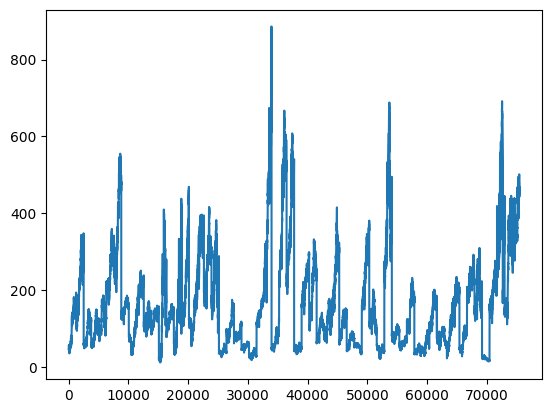

In [8]:
plt.plot(np.arange(ohlc_data.shape[0]*ohlc_data.shape[1]), ohlc_data[:,:,-1].flatten())

In [9]:
ohlc_data_with_indciators = torch.cat((ohlc_data, macd_data, rsi_data, cci_data), dim = 2)
print(ohlc_data_with_indciators.shape)
print(ohlc_data_with_indciators.max())
print(ohlc_data_with_indciators[0, :10, 3])

torch.Size([60, 1258, 7])
tensor(921.7799)
tensor([46.3500, 46.9925, 47.6450, 47.5875, 46.9700, 47.7575, 47.8325, 47.7275,
        47.8625, 47.6000])


In [10]:
class CurrentStockDset(Dataset):
    def __init__(self, data, src_length, tgt_length, maxes = None, mins = None):
        self.data = data
        if maxes == None and mins == None:
            self.mins, _ = torch.min(self.data, dim = 1, keepdim = True)
            self.data = self.data - self.mins
            self.maxes, _ = torch.max(self.data, dim = 1, keepdim = True)
            self.data = self.data / self.maxes
        elif maxes != None and mins != None:
            self.mins = mins
            self.data = self.data - self.mins
            self.maxes = maxes
            self.data = self.data / self.maxes
        else:
            raise Exception("only maxes or only mins given")
        
        self.src_length = src_length
        self.tgt_length = tgt_length
        self.unit_length = self.data.shape[1] - (self.src_length + self.tgt_length) + 1

    def __len__(self):
        return self.unit_length*self.data.shape[0]

    def __getitem__(self, idx):
        ticker_idx = idx//self.unit_length
        request_idx = idx - (ticker_idx*self.unit_length) + (self.src_length + self.tgt_length)
        src = self.data[ticker_idx, request_idx - (self.src_length+self.tgt_length): request_idx - self.tgt_length]
        tgt = self.data[ticker_idx, request_idx - self.tgt_length: request_idx]
        return src, tgt, (request_idx - (self.src_length+self.tgt_length),request_idx - self.tgt_length, request_idx)
    

def generate_square_subsequent_mask(dim1: int, dim2: int) -> torch.Tensor:
    """
    Generates an upper-triangular matrix of -inf, with zeros on diag.
    Source:
    https://pytorch.org/tutorials/beginner/transformer_tutorial.html
    Args:
        dim1: int, for both src and tgt masking, this must be target sequence
              length
        dim2: int, for src masking this must be encoder sequence length (i.e. 
              the length of the input sequence to the model), 
              and for tgt masking, this must be target sequence length 
    Return:
        A Tensor of shape [dim1, dim2]
    """
    return torch.triu(torch.ones(dim1, dim2) * float('-inf'), diagonal=1)

def traintest_split(data, train_length, src_length, tgt_length):
    train_dset = CurrentStockDset(
        data[:, :train_length],
        src_length,
        tgt_length
    )
    test_dset = CurrentStockDset(
        data[:, train_length-src_length:],
        src_length,
        tgt_length,
        maxes = train_dset.maxes,
        mins = train_dset.mins
    )
    return train_dset, test_dset

train_dset, test_dset = traintest_split(ohlc_data_with_indciators, 1000, 40, 1)
"""
for _,_,idx in train_dset:
    print(idx)
for _,_,idx in test_dset:
    idx = (
        idx[0]+1000 - 10,
        idx[1]+1000 - 10,
        idx[2]+1000 - 10
    )
    print(idx)
"""
# I strongly believe this is working properly
print(len(train_dset), len(test_dset))
print(train_dset.maxes.shape, train_dset.data.max())
train_dataloader = DataLoader(train_dset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dset, batch_size=64, shuffle=False)

57600 15480
torch.Size([60, 1, 7]) tensor(1.)


In [11]:
"""
class InputEmbedding(nn.Module):
    def __init__(self, d_model: int = 32):
        super().__init__()
        self.fc1 = nn.Linear(7, d_model//4)
        self.fc2 = nn.Linear(d_model//4, d_model//2)
        self.fc3 = nn.Linear(d_model//2, d_model)
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)
        
"""
class InputEmbedding(nn.Module):
    def __init__(self, d_model: int = 32, input_size = 40):
        super().__init__()
        self.conv1 = nn.Conv1d(7, d_model//4, 5, stride = 1, padding = 2, padding_mode = 'reflect')
        self.bn1 = nn.BatchNorm1d(d_model//4)
        self.conv2 = nn.Conv1d(d_model//4, d_model//2, 3, stride = 1, padding = 1, padding_mode = 'reflect')
        self.bn2 = nn.BatchNorm1d(d_model//2)
        self.fc3 = nn.Linear(
            d_model // 2,
            d_model
        )
        self.relu = nn.ReLU(inplace = True)
        
    def forward(self, x):
        x = x.permute(1,2,0)
        x = self.relu(self.conv1(x))
        #x = self.bn1(x)
        x = self.relu(self.conv2(x))
        #x = self.bn2(x)
        return self.fc3(x.permute(2,0,1))
#"""

class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float, max_len: int):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)
"""  
class MyScuffedTransformer(nn.Module):
    def __init__(self, d_model: int = 32, dropout: float = 0.1, max_len: int = 40):
        super().__init__()
        self.embedding = InputEmbedding(d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout = dropout, max_len = max_len)
        self.transformer = nn.Transformer(nhead=4, d_model = d_model, dim_feedforward = d_model * 4, layer_norm_eps = 1e-8)
        self.fc = nn.Linear(d_model, 1)
        self.d_model = d_model
    
    def forward(self, src, tgt, src_mask, tgt_mask):
        src = self.embedding(src) * math.sqrt(self.d_model)
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)
        src = self.positional_encoding(src)
        tgt = self.positional_encoding(tgt)
        output = self.transformer(src, tgt, src_mask=src_mask, tgt_mask=tgt_mask)
        return self.fc(output)
#"""

class MyScuffedTransformerEnc(nn.Module):
    def __init__(self, d_model: int = 32, dropout: float = 0.1, max_len: int = 40):
        super().__init__()
        self.embedding = InputEmbedding(d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout = dropout, max_len = max_len)
        encoder_layer = nn.TransformerEncoderLayer(nhead=4, d_model = d_model, dim_feedforward = d_model * 4, layer_norm_eps = 1e-8)
        self.transformer_enc = nn.TransformerEncoder(encoder_layer, 6, norm = nn.LayerNorm(d_model))
        self.fc = nn.Linear(d_model*max_len, 7)
        self.d_model = d_model

    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.positional_encoding(src)
        output = self.transformer_enc(src).permute(1,0,2)
        output = output.reshape(output.shape[0], -1)
        output = self.fc(output).unsqueeze(0)
        return output
#"""

In [12]:
def train_epoch(model, trainloader, idx):
    model.train()
    total_loss = 0.0
    for src, tgt, _ in trainloader:
        opt.zero_grad()
        src, tgt = src.permute(1,0,2).to(device), tgt.permute(1,0,2).to(device)
        #print(src.shape, tgt.shape)
        decoder_input = torch.cat((src[-1:], tgt[:-1]), dim = 0)
        #print(decoder_input.shape)
        #tgt_mask = generate_square_subsequent_mask(
        #    dim1=1,
        #    dim2=1
        #).to(device)
        #src_mask = generate_square_subsequent_mask(
        #    dim1=40,
        #    dim2=40
        #).to(device)
        #output = model(src, decoder_input, src_mask, tgt_mask)
        #output = model(src, src_mask)
        output = model(src)
        #loss = loss_fn(output, tgt[:,:,3])
        loss = loss_fn(output[:,:,idx], tgt[:,:,idx])
        total_loss += loss.item()
        loss.backward()
        #print(loss.item())
        opt.step()
        scheduler.step()
    return total_loss/len(trainloader)
    
@torch.no_grad()
def test_model(model, testloader, idx):
    model.eval()
    total_loss = 0.0
    for src, tgt, _ in testloader:
        src, tgt = src.permute(1,0,2).to(device), tgt.permute(1,0,2).to(device)
        #print(src.shape, tgt.shape)
        #decoder_input = torch.cat((src[-1:], tgt[:-1]))      
        #tgt_mask = generate_square_subsequent_mask(
        #    dim1=1,
        #    dim2=1
        #).to(device)
        #src_mask = generate_square_subsequent_mask(
        #    dim1=40,
        #    dim2=40
        #).to(device)
        #output = model(src, decoder_input, src_mask, tgt_mask)
        #output = model(src, src_mask)
        output = model(src)
        #loss = loss_fn(output, tgt[:,:,3])
        loss = loss_fn(output[:,:,idx], tgt[:,:,idx])
        total_loss += loss.item()
    return total_loss/len(testloader)

def fit_model(num_epochs, model, trainloader, testloader, idx):
    pbar = tqdm(range(num_epochs))
    train_losses = []
    test_losses = []
    for epoch in pbar:
        avg_loss = train_epoch(model, trainloader, idx)
        test_loss = test_model(model, testloader, idx)
        pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
        pbar.set_postfix(loss=avg_loss, test_loss = test_loss)
        train_losses.append(avg_loss)
        test_losses.append(test_loss)
    return train_losses, test_losses

In [13]:
model = MyScuffedTransformerEnc(d_model = 32).to(device)
num_epochs = 100
loss_fn = nn.MSELoss()
lr = 1e-3
opt = torch.optim.Adam(model.parameters(), lr = lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0 = 10, eta_min = 3e-4)
train_losses, test_losses = fit_model(num_epochs, model, train_dataloader, test_dataloader, idx = np.arange(7))
general_model_savename = datetime.datetime.now().isoformat(timespec = 'hours')+'.pth'
general_model_path = os.path.join('model_saves', 'general_models', general_model_savename)
torch.save(
    {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': opt.state_dict(),
        'train_loss': train_losses,
        'test_loss': test_losses
    }, 
    general_model_path)

Epoch [100/100]: 100%|██████████████████████████████| 100/100 [20:31<00:00, 12.32s/it, loss=0.00128, test_loss=0.00575]


In [12]:
#general_model_savename = '2023-07-03T13.pth'

C:\Users\Ian Mackey\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\optim\lr_scheduler.py:1379: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


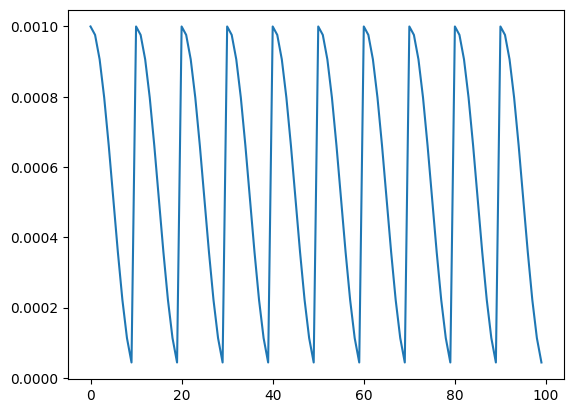

In [15]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(opt, T_0 = 10, eta_min = 2e-5)
lrs = []
for i in range(100):
    lrs.append(scheduler.get_lr())
    scheduler.step()
plt.plot(np.arange(len(lrs)), lrs)


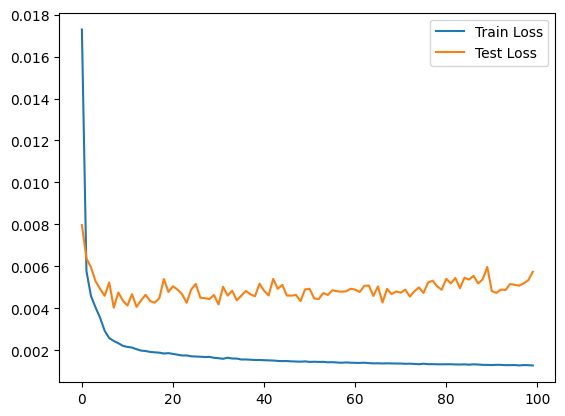

In [14]:
checkpoint = torch.load(general_model_path)
train_losses = checkpoint['train_loss']
test_losses = checkpoint['test_loss']
plt.plot(np.arange(num_epochs), train_losses, label = 'Train Loss')
plt.plot(np.arange(num_epochs), test_losses, label = 'Test Loss')
plt.legend()

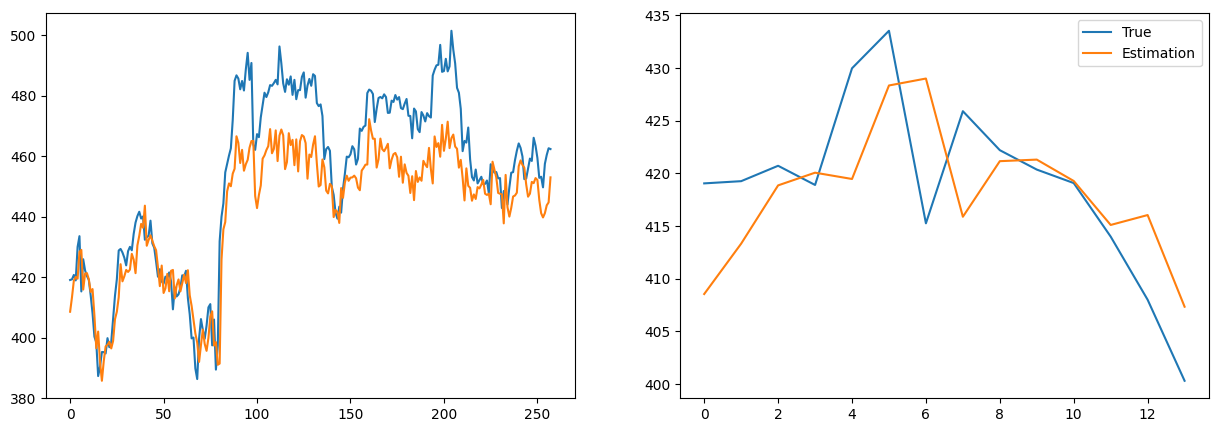

In [19]:
import matplotlib.pyplot as plt

@torch.no_grad()
def make_plots(model, testloader, plot_idx):
    model.eval()
    y_true = []
    y_est = []
    for src, tgt, idx in testloader:
        src, tgt = src.permute(1,0,2).to(device), tgt.permute(1,0,2).to(device)
        #decoder_input = torch.cat((src[-1:], tgt[:-1]))      
        #tgt_mask = generate_square_subsequent_mask(
        #    dim1=1,
        #    dim2=1
        #).to(device)
        #src_mask = generate_square_subsequent_mask(
        #    dim1=40,
        #    dim2=40
        #).to(device)
        #output = model(src, decoder_input, src_mask, tgt_mask)
        output = model(src)
        #print(tgt.shape)
        #print(output.shape)
        y_true.append(tgt[:,:,3].to('cpu').reshape(-1))
        y_est.append(output[:,:,3].to('cpu').reshape(-1))
    y_true = torch.cat(y_true)
    y_est = torch.cat(y_est)
    y_true = (y_true.reshape(-1, test_dset.unit_length)*test_dset.maxes[:,:,3])+test_dset.mins[:,:,3]
    y_est = (y_est.reshape(-1, test_dset.unit_length)*test_dset.maxes[:,:,3])+test_dset.mins[:,:,3]
    #y_true, y_est = torch.cat(y_true).reshape(train_dset.unit_length, -1), torch.cat(y_est).reshape(train_dset.unit_length, -1)
    #y_true, y_est = y_true.permute(1,0)*1000, y_est.permute(1,0)*1000
    fig, axes = plt.subplots(1,2, figsize = (15,5))
    axes[0].plot(np.arange(test_dset.unit_length)[:], y_true[plot_idx], label = "True")
    axes[0].plot(np.arange(test_dset.unit_length)[:], y_est[plot_idx], label = "Estimation")
    axes[1].plot(np.arange(test_dset.unit_length)[:14], y_true[plot_idx,:14], label = "True")
    axes[1].plot(np.arange(test_dset.unit_length)[:14], y_est[plot_idx,:14], label = "Estimation")
    plt.legend()
    
make_plots(model, test_dataloader, 0)

In [16]:
for stock_idx in range(ohlc_data.shape[0]):
    train_dset, test_dset = traintest_split(ohlc_data_with_indciators[stock_idx:stock_idx+1], 1000, 40, 1)
    train_dataloader = DataLoader(train_dset, batch_size=64, shuffle=True)
    test_dataloader = DataLoader(test_dset, batch_size=64, shuffle=False)
    checkpoint = torch.load(general_model_path)
    model = MyScuffedTransformerEnc(d_model = 32).to(device)
    model.load_state_dict(checkpoint['model_state_dict'])
    num_epochs = 100
    loss_fn = nn.MSELoss()
    lr = 3e-4
    opt = torch.optim.Adam(model.parameters(), lr = lr)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(opt, T_max=num_epochs) 
    train_losses, test_losses = fit_model(num_epochs, model, train_dataloader, test_dataloader, 3)
    model_savename = general_model_savename[:-4] + '_' + str(stock_idx) +'.pth'
    torch.save(
        {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': opt.state_dict(),
            'train_loss': train_losses,
            'test_loss': test_losses
        }, 
        os.path.join('model_saves', 'finetuned_models', model_savename))

Epoch [100/100]: 100%|█████████████████████████████| 100/100 [00:22<00:00,  4.45it/s, loss=0.000247, test_loss=0.00458]


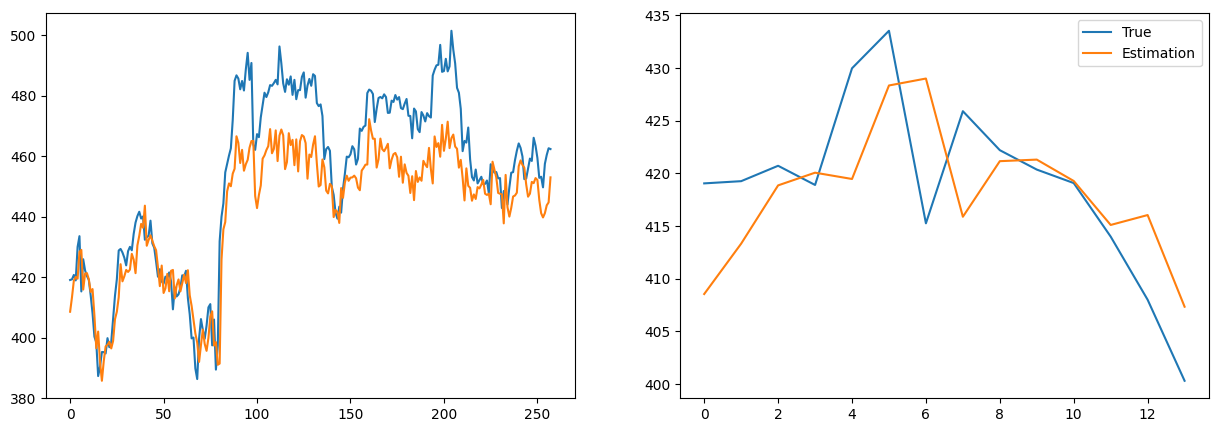

In [23]:
make_plots(model, test_dataloader, 0)